# Building a Predictive Model of Malignant Breast Cancer using Logistic Regression with L1-Penalty
An interactive result by Aaron Kelly 

699 samples of breast tumors were used for this analysis, with 9 covariates measured to be associated with malignancy. 458 of the samples are benign, and 241 of them are malignant. Using logistic regression and balancing the samples in the training set, I was able to achieve an AUC (area under the curve) on my predicted probabilities of 0.999.

The covariates are all known to be indicative of cancer to begin with and are coded as follows:
clump_thick = The thickness of cell clumps, scaled to 1-10 scores. 
size_unif = The uniformity of cell size in the sample, 1 being most uniform, 10 being least uniform. 
shape_unif = The uniformity of cell shape, 1 being most uniform, 10 being least uniform. 
marg_adh = The marginal adhesion abilities for cells, 10 being the least adhesive. 
epith_size = Size of a single epithelial cell, 10 being the largest. 
bare_nucl = Level of bare nuclei (nuclei with scant or absent cytoplasm) seen, indicating cell degradation (10 most). 
bland_chrom = Coarseness of chromatin, where 10 is the most coarse, 1 is the most "bland"
norm_nucl = Size and prominence of nucleoli, 10 being the most prominent. 
mitoses = Level of cell budding occurring, 10 being most. Cancer cells tend to divide more rapidly. 

'Class' is the target variable. It is coded such that 2 = benign and 4 = malignant. 

In [182]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import math
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split

### Here I will read in the data and do a sanity check to make sure it is in the right structure. 

In [245]:
# Read data into notebook as pandas dataframe
# Note that I added column names to data and converted it to a .csv prior to this step. 
data = pd.read_csv('breast-cancer-wisconsin.data.csv')
## Look at the data to make sure it got read in right. 
print 'Total samples prior to NaN removal', data.shape[0]
col = data.columns[1:(len(data.columns)-1)]
print data.head()
print 'Num_benign:', sum(data['class'] == 2), '  Num_malignant:', sum(data['class'] == 4)
## Remove columns where bare_nucl is NaN
data = data[pd.notnull(data['bare_nucl'])]
print 'Total samples after NaN removal:', data.shape[0]

Total samples prior to NaN removal 699
   tumor_id  clump_thick  size_unif  shape_unif  marg_adh  epith_size  \
0   1000025            5          1           1         1           2   
1   1002945            5          4           4         5           7   
2   1015425            3          1           1         1           2   
3   1016277            6          8           8         1           3   
4   1017023            4          1           1         3           2   

   bare_nucl  bland_chrom  norm_ncloli  mitoses  class  
0        1.0            3            1        1      2  
1       10.0            3            2        1      2  
2        2.0            3            1        1      2  
3        4.0            3            7        1      2  
4        1.0            3            1        1      2  
Num_benign: 458   Num_malignant: 241
Total samples after NaN removal: 683


### Everything looks great. Let's put the data into structures for the target and predictive variables, and sub-sample into training and test sets. I booted 25% out for testing here, and won't bother with cross validation, as the model I am training uses cross-validation to select the parameters. 

In [195]:
# Reformat x and y data
x = data[col]
samp = np.random.choice(data.shape[0] - 1, int(math.floor(.75*data.shape[0])), replace=False)
y = data['class']
# Sample into training and test sets
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.25)
print x_tr.shape, len(y_tr), x_ts.shape, len(y_ts)

(512, 9) (171, 9) 512 171


### All looking good! Note that above there are 512 samples in the training data, and 171 in the test. Now let's fit the model. 

Num of tn, tp, fn, and fp (in order):
(2, 2)    106
(4, 4)     60
(2, 4)      4
(4, 2)      1
dtype: int64


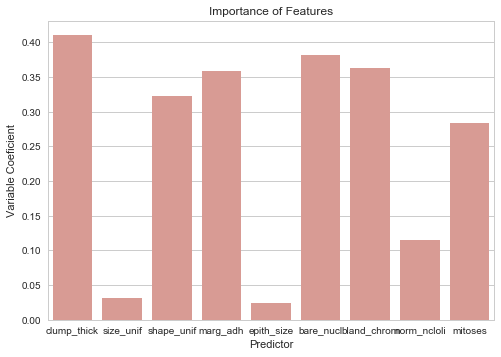

In [249]:
## Fit logistic regression model using the L1 pentalty (i.e. Lasso)
# Note that the liblinear function is okay for smaller sample sizes but can give problems for large samples
# but it is a more exact solution
# Also note that after trying otherwise, using a balanced class weight, i.e. biasing towards choosing
# more malignant samples in the training data, seemed to work better. 
mod = lm.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
mod.fit(x_tr, y_tr)
cf = mod.coef_ # The beta coeficients of the fit model. 
cl_pred = mod.predict(x_ts) # The prediction, already binarized by the chosen default cutoff 
# Print number of true negatives (tn), true positives (tp), false negatives (fn), and false positives (fp)
dats = zip(cl_pred, np.array(y_ts))
ser = pd.Series([tuple(i) for i in dats])
print 'Num of tn, tp, fn, and fp (in order):\n', ser.value_counts()
# Plot the final variable beta values. 
df = pd.DataFrame(data={'Predictor': np.array(col).ravel(), 'Coefficient': np.array(cf).ravel()})
seaborn.set_style("whitegrid")
pl = seaborn.barplot(x='Predictor', y='Coefficient', data = df, color="salmon", saturation=.5)
pl.set_ylabel('Variable Coeficient')
pl.set_title('Importance of Features')
seaborn.plt.show()


### Model already looks fantastic when using the chosen cutoffs for the model! Note that clump thickness, bare nuclei, coarse chromatin, low marginal adhesion, poor cell shape uniformity, and mitoses all are strong predictors of the phenotype, even after regularization. Wow! 

Below, we will take a little deeper look. I will output the model probability predictions instead of class predictions. This will allow me to iterate through cutoffs to look at the FP and TP rates, resulting in an ROC curve. 

AUC= 0.998539719626


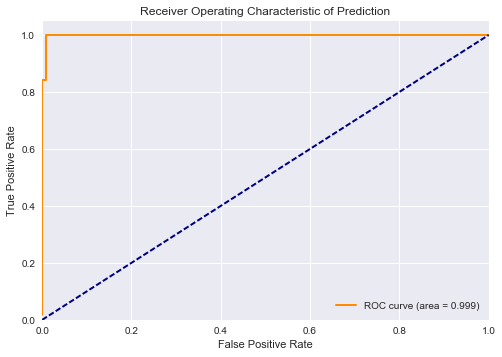

In [212]:
# Compute roc curve and auc. 
pred = mod.predict_proba(x_ts)[:, 1]
tr = (y_ts/2)-1
fpr, tpr, thresholds = skl.metrics.roc_curve(y_true=tr, y_score=pred)
auc = skl.metrics.auc(fpr, tpr)
print 'AUC=', auc

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Prediction')
plt.legend(loc="lower right")
plt.show()

# Holy buckets, it worked well! 
An AUC that close to 1 indicates that there is very little tradeoff that needs to be made between TPR and FPR! That is good news in terms of using this model diagnostically. 